# Introduction  

Welcome to the Petals to the Metal competition! In this competition, you’re challenged to build a machine learning model to classify 104 types of flowers based on their images.
In this tutorial notebook, you'll learn how to build an image classifier in Keras and train it on a Tensor Processing Unit (TPU). At the end, you'll have a complete project you can build off of with ideas of your own.

To improve classification accuracy of the model on the test dataset, the following are explored:

* Input image size
* Pretrained model and number of trainable parameters of final model
* Data augmentation
* Regularization techniques
* Use of learning rate schedule



# Step 0 : Import Libraries

we begin this notebook by importing useful analytics libraries, in which we import statistical, data visualization and milidating overfitting libraries along with tensorflow and keras.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed on Kaggle
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import os
import re
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random       
import plotly.express as px
import tensorflow as tf
from tensorflow.keras import regularizers      # mitigate overfitting 
from kaggle_datasets  import KaggleDatasets    # import kaggle data files
# Stop training when a monitored metric has stopped improving
from tensorflow.keras.callbacks import EarlyStopping   
print("Tensorflow version " + tf.__version__)  # verify tensorflow versionis 2.x

# Step 1: Distribution Strategy
A TPU has eight different cores and each of these cores acts as its own accelerator. (A TPU is sort of like having eight GPUs in one machine.) We tell TensorFlow how to make use of all these cores at once through a distribution strategy. Run the following cell to create the distribution strategy that we'll later apply to our model.

### What TPUClusterResolver() does? <br>
TPUs are network-connected accelerators and you must first locate them on the network. In TPUStrategy, the main object is to contain the necessary distributed training code that will work on TPUs with their 8 compute cores. Whenever, you use the TPUStrategy by instantiating your model in the scope of the strategy. This creates the model on the TPU. Model size is constrained by the TPU RAM only, not by the amount of memory available on the VM running your Python code. Model creation and model training use the usual Keras APIs. Further read about [TPUClusterResolver() ](https://www.tensorflow.org/api_docs/python/tf/distribute/cluster_resolver/ClusterResolver) and
[Kaggle TPU Doc](https://www.kaggle.com/docs/tpu)

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. 
    # On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

We'll use the distribution strategy when we create our neural network model. Then, TensorFlow will distribute the training among the eight TPU cores by creating eight different replicas of the model, one for each core.

# Step 2: Loading The Competition Data

### Get GCS Path
When used with TPUs, datasets need to be stored in a [Google Cloud Storage](https://cloud.google.com/storage/) bucket. You can use data from any public GCS bucket by giving its path just like you would data from '/kaggle/input'. The following will retrieve the GCS path for this competition's dataset.

In [ ]:
# you can list the bucket with "!gsutil ls $GCS_DS_PATH"
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH)

You can use data from any public dataset here on Kaggle in just the same way. If you'd like to use data from one of your private datasets, see [here](https://www.kaggle.com/docs/tpu#tpu3pt5).


# Data Directories

In [ ]:
# Input data files are available in the read-only "kaggle/input/" directory
#   image files are in TFRecords format, each of which contains a sequeence
#   of records and can only be read sequentially.

TFRec_selected = '512x512'
for dirpath, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if TFRec_selected in dirpath: # 
            print(os.path.join(dirpath, filename))

# Step 3: Loading Data (Setting up the parameters)








When used with TPUs, datasets are often serialized into [TFRecords](https://www.kaggle.com/ryanholbrook/tfrecords-basics). This is a format convenient for distributing data to each of the TPUs cores. We've hidden the cell that reads the TFRecords for our dataset since the process is a bit long. You could come back to it later for some guidance on using your own datasets with TPUs.

TPU's is basically used to allocate the larger models having huge training inputs and batches, equipped with upto 128GB of high-speed memory allocation. In this notebook, we used images dataset having pixel size is 512 x 512px, and see how TPU v3-8 handle it.
* num_parallel_reads=AUTO is used to automatically read multiple file.
* experimental_deterministic = False, we used "experimental_deterministic" to maintain the order of the data. Here, we disable the enforcement order to shuffle the data anyway.



In [ ]:
IMAGE_SIZE = [512, 512] 

GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.experimental.AUTOTUNE 

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

# 100 - 103

print (CLASSES)

### Functions to Handle the Data

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),    # shape [] means single element
        # class is missing, to be predicted flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of (image, idnum) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    
    # automatically interleaves reads from multiple file
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order) 
    
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    dataset = dataset.map(read_labeled_tfrecord if labeled 
                          else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset


### Tuning the Additional [Flower Data](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec)

To increase the proficiiency of data, I have to use the external flower dataset with the helping material from [Dmitry's](https://www.kaggle.com/dmitrynokhrin/densenet201-aug-additional-data) and [Araik's ](https://www.kaggle.com/atamazian/fc-ensemble-external-data-effnet-densenet)notebook. To visit the notebook to better understanding of the Ensamble learning and augmentation of the external dataste.

In [ ]:
GCS_DS_PATH_EXT = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

# External data
GCS_PATH_SELECT_EXT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
GCS_PATH_EXT = GCS_PATH_SELECT_EXT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/imagenet' + GCS_PATH_EXT + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/inaturalist' + GCS_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/openimage' + GCS_PATH_EXT + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/oxford_102' + GCS_PATH_EXT + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(GCS_DS_PATH_EXT + '/tf_flowers' + GCS_PATH_EXT + '/*.tfrec')

ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES

In [ ]:
# parameters set for tfrecords-jpeg-512x512 TFRecord files
IMAGE_SIZE        = [512, 512] 
HEIGHT            = IMAGE_SIZE[0]
WIDTH             = IMAGE_SIZE[1]
EPOCHS            = 20
BATCH_SIZE        = 16 * strategy.num_replicas_in_sync
NUM_TRAIN_IMAGES  = 12753
NUM_VAL_IMAGES    = 3712
NUM_TEST_IMAGES   = 7382
STEPS_PER_EPOCH   = NUM_TRAIN_IMAGES // BATCH_SIZE
AUTO              = tf.data.experimental.AUTOTUNE
TRAIN_FILENAMES   = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/train/*.tfrec') 
VAL_FILENAMES     = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/val/*.tfrec') 
TEST_FILENAMES    = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords-jpeg-512x512/test/*.tfrec')

### Data Augmentation of the External Data

Note: In-depth understanding of the data augmentation, visit [Dmitry's Notebook](https://www.kaggle.com/dmitrynokhrin/densenet201-aug-additional-data)


In [ ]:
SEED = 2020

def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left

        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

    
def data_augment_v2(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    
    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01
    
    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)
        
    image = random_blockout(image)
    
    return image, label 

### Data Augmentation
Inspired from Xuanzhi Huang and Rahul Paul's [notebook](https://www.kaggle.com/xuanzhihuang/flower-classification-densenet-201)



TensorFlow Addons is a repository of contributions that conform to well-established API patterns, but implement new functionality not available in core TensorFlow. TensorFlow natively supports a large number of operators, layers, metrics, losses, and optimizers. [Read out more]([https://github.com/tensorflow/addons]) 

In [ ]:
import tensorflow_addons as tfa

# Randomly make some changes to the images and return the new images and labels
def data_augment_v3(image, label):
        
    # Set seed for data augmentation
    seed = 100
    
    # Randomly resize and then crop images
    image = tf.image.resize(image, [720, 720])
    image = tf.image.random_crop(image, [512, 512, 3], seed = seed)

    # Randomly reset brightness of images
    image = tf.image.random_brightness(image, 0.6, seed = seed)
    
    # Randomly reset saturation of images
    image = tf.image.random_saturation(image, 3, 5, seed = seed)
        
    # Randomly reset contrast of images
    image = tf.image.random_contrast(image, 0.3, 0.5, seed = seed)

    # Randomly reset hue of images, but this will make the colors really weird, which we think will not happen
    # in common photography
    # image = tf.image.random_hue(image, 0.5, seed = seed)
    
    # Blur images
    image = tfa.image.mean_filter2d(image, filter_shape = 10)
    
    # Randomly flip images
    image = tf.image.random_flip_left_right(image, seed = seed)
    image = tf.image.random_flip_up_down(image, seed = seed)
    
    # Fail to rotate and transform images due to some bug in TensorFlow
    # angle = random.randint(0, 180)
    # image = tfa.image.rotate(image, tf.constant(np.pi * angle / 180))
    # image = tfa.image.transform(image, [1.0, 1.0, -250, 0.0, 1.0, 0.0, 0.0, 0.0])
    
    return image, label


# **Step4: Data Pipelines**

In [ ]:
# image augmentation                                  
def data_augment(image, label):
    # Pad the image with a black, 3-pixel border
    # image = tf.image.resize_with_crop_or_pad(image, HEIGHT + 6, WIDTH + 6)
    # Randomly crop to original size from the padded image
    # image = tf.image.random_crop(image, size=[*IMAGE_SIZE,3])
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_contrast(image, 0.8, 1.2)
    #image = tf.image.random_brightness(image, 0.1) 
    #image = tf.image.random_saturation(image, 0.7, 1.3)
    return image, label 

# get training datatset with augmentation option
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [ ]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

**To make TPU faster, increase the batch size**


In [ ]:
strategy.num_replicas_in_sync

In [ ]:
16 * strategy.num_replicas_in_sync

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_validation_dataset()


print("Training:" , ds_train)
print("Validation:" , ds_valid)
print("Testing: ", ds_test)

These datasets are tf.data.Dataset objects. You can think about a dataset in TensorFlow as a stream of data records. The training and validation sets are streams of (image, label) pairs.

In [ ]:
np.set_printoptions(threshold=15, linewidth=80)


print("Training DataStream Shape: ")
for image, label in ds_train.take(5):
    print(image.numpy().shape, label.numpy().shape)
print("Training datasteam label examples: ", label.numpy())
    

The test set is a stream of (image, idnum) pairs; idnum here is the unique identifier given to the image that we'll use later when we make our submission as a csv file

In [ ]:
print("Test DataStream Shape: ")
for image, idnum in ds_test.take(5):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test datasteam IDs examples: ", idnum.numpy().astype('U'))

# **Step5: Data Exploration**

In [ ]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels
    

In [ ]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 
                                'OK' if correct else 'NO', 
                                u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

In [ ]:
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

In [ ]:
def display_batch_of_images(databatch, predictions=None, display_mismatches_only=False):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        if display_mismatches_only:
            if predictions[i] != label:
                subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
        else:        
            subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


In [ ]:
def display_training_curves_v2(training, validation, learning_rate_list, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title, color='b')
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.', 'learning rate'])        
    
    ax2 = ax.twinx() #The Axes. twinx() function in axes module of matplotlib library is used to create a twin Axes sharing the xaxis. 
    ax2.plot(learning_rate_list, 'g-')
    ax2.set_ylabel('learning rate', color='g')

You can display a single batch of images from a dataset with another of our helper functions. The next cell will turn the dataset into an iterator of batches of 50 images.

### Image Analysis with or without Augmentation 

In [ ]:
# get original training_dataset without augmentation
ori_train_set = get_training_dataset()

ori_image_batch = (next(iter(ori_train_set.unbatch().batch(16)))) # get a batch for 
images, _ = batch_to_numpy_images_and_labels(ori_image_batch)

# function to show image with random data augmentation
def show_aug(image):
    plt.figure(figsize=(12,2))
    plt.subplot(1,6,1)
    plt.imshow(image)
    plt.title('no augmentation')
    plt.axis('off')
    plt.subplot(1,6,3)
    plt.imshow(tf.image.random_flip_left_right(image))       # augmented with random flip
    plt.title('rdm flip L/R')
    plt.axis('off')    
    plt.subplot(1,6,4)
    plt.imshow(tf.image.random_contrast(image, 0.90, 0.99))  # augmented with contrast
    plt.title('rdm contrast')
    plt.axis('off')
    plt.subplot(1,6,5)
    plt.imshow(tf.image.random_brightness(image, 0.1))       # augmented with brightness
    plt.title('rdm brightness')
    plt.axis('off')
    plt.subplot(1,6,6)
    plt.imshow(tf.image.random_saturation(image, 0.8, 0.9))  # augmented with saturation
    plt.title('rdm saturation')
    plt.axis('off')
    plt.subplot(1,6,2)
    image = data_augment(image, None)
    plt.imshow(image[0])  # any random combinations of the above augmenations, if any
    plt.title('rdm aug combo')
    plt.axis('off')    
    plt.show()

# show images
print('Training Dataset')
print('Sample Images: Original versus w/ Random Augmentation')
for im in images:
    show_aug(im)

In [ ]:
ds_iter = iter(ds_train.unbatch().batch(50))

#Use the Python next function to pop out the next batch in the stream and display it with the helper function.
one_batch = next(ds_iter)
display_batch_of_images(one_batch)


In [ ]:
ds_iter = iter(ds_train.unbatch().batch(50))

#Use the Python next function to pop out the next batch in the stream and display it with the helper function.
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

# **Step6: Data Augmentation Sample**

In [ ]:
row = 4
col = 4
Batch_elements = get_training_dataset().unbatch()
single_element = tf.data.Dataset.from_tensors(next(iter(Batch_elements)))
# Map the images to the data augmentation function for image processing
augmented_element = single_element.repeat().map(data_augment).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

## Data Augmentation Sample V2 (Implementing Image Processing)

In [ ]:
# Map the images to the data augmentation function for image processing
augmented_element = single_element.repeat().map(data_augment_v2).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        #plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

## Data Augmentation Sample V3 (Implementing Image Processing)

In [ ]:
augmented_element = single_element.repeat().map(data_augment_v3).batch(row * col)

for (img, label) in augmented_element:
    plt.figure(figsize = (15, int(15 * row / col)))
    for j in range(row * col):
        plt.subplot(row, col, j + 1)
        plt.axis('off')
        plt.imshow(img[j, ])
    plt.show()
    break

# **Step7: Defining The Model**

Now we're ready to create a neural network for classifying images! We'll use what's known as transfer learning. With transfer learning, you reuse part of a pretrained model to get a head-start on a new dataset.

For this tutorial, we'll to use a model called VGG16 pretrained on [ImageNet](https://image-net.org/)). Later, you might want to experiment with [other models ](https://www.tensorflow.org/api_docs/python/tf/keras/applications)included with Keras. ([Xception](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception) wouldn't be a bad choice.)

The distribution strategy we created earlier contains a [context manager](https://docs.python.org/3/reference/compound_stmts.html#with), strategy.scope. This context manager tells TensorFlow how to divide the work of training among the eight TPU cores. When using TensorFlow with a TPU, it's important to define your model in a strategy.scope() context.

In [ ]:
# Check the image size(dimensions) before training the data
[*IMAGE_SIZE, 3]

In [ ]:
",".join(tf.keras.applications.__dir__())

## To kepp track the model performance and findout the best suitable model through model-monitoring instance

In [ ]:
checkpoint_filepath = "Petals_to_the_Metal-70K_images-trainable_True-MobileNetV2.h5" #"Petals_to_the_Metal-70K_images-trainable_True-DenseNet201.h5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs. 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### Important : How to track learning rate during model training?

Note: Stochastic gradient descent is an optimization algorithm that estimates the error gradient for the current state of the model using examples from the training dataset, then updates the weights of the model using the back-propagation of errors algorithm, referred to as simply backpropagation.
The amount that the weights are updated during training is referred to as the step size or the “learning rate.”
Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.
For more information review the article of Jason Brownlee "[How to Configure the Learning Rate When Training Deep Learning Neural Networks](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)"

[Track learning rate during Training](https://stackoverflow.com/questions/49127214/keras-how-to-output-learning-rate-onto-tensorboard)
NotFoundError: Container worker does not exist. (Could not find resource: worker/_AnonymousVar8064) Encountered when executing an operation using EagerExecutor. This error cancels all future operations and poisons their output tensors.

In [ ]:
NotFoundError = """
class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):  # add other arguments to __init__ if you need
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super().on_epoch_end(epoch, logs)

lr_tracking = LRTensorBoard(log_dir="./lr_tracking")
"""

### Tuning Custom [Callbacks](https://www.tensorflow.org/guide/keras/custom_callback)

In [ ]:
class LearningRateTracking(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        
        #logs = logs or {}
        #logs.update({'lr': K.eval(self.model.optimizer.lr)}) #optimizer._decayed_lr('float32').numpy()
        #return 

#lr_tracking = LearningRateTracking()

# For reading about EfficientNetB7 visit https://keras.io/api/applications/efficientnet/#efficientnetb7-function
use_efficientnet = False #tuning9
if use_efficientnet:
    !pip install -q efficientnet
    from efficientnet.tfkeras import EfficientNetB7  

### Calculate the Weight of each [Flower Class](https://www.kaggle.com/xuanzhihuang/flower-classification-densenet-201)

In [ ]:
weight_per_class = True

if weight_per_class:
    from collections import Counter
    import gc #Garbage Collector https://docs.python.org/3/library/gc.html

    gc.enable() #Enable automatic garbage collection.

    def get_training_dataset_raw():
        dataset = load_dataset(TRAINING_FILENAMES, labeled = True, ordered = False)
        return dataset

    raw_training_dataset = get_training_dataset_raw()

    label_counter = Counter()
    for images, labels in raw_training_dataset:
        label_counter.update([labels.numpy()])

    del raw_training_dataset    

    TARGET_NUM_PER_CLASS = 122 #?

    def get_weight_for_class(class_id):
        counting = label_counter[class_id]
        weight = TARGET_NUM_PER_CLASS / counting
        return weight

    weight_per_class = {class_id: get_weight_for_class(class_id) for class_id in range(104)}
    
if weight_per_class:
    data = pd.DataFrame.from_dict(weight_per_class, orient='index', columns=['class_weight'])
    plt.figure(figsize=(30, 9))

    #barplot color based on value
    bplot = sns.barplot(x=data.index, y='class_weight', data=data, palette= cm.Blues(data['class_weight']*0.15));
    for p in bplot.patches:
        bplot.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    plt.xlabel("Class", size=14)
    plt.ylabel("Class weight (inverse of %)", size=14)

### **Ensemble Learning Sample Code**

In [ ]:
"""Model_type = "Model1"
EPOCHS = 15

#DenseNet201
def get_model1():
    with strategy.scope():
        dn201 = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        dn201.trainable = True # Full Training

        model1 = tf.keras.Sequential([
            dn201,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

    model1.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model1

#Efficient Net B7
def get_model2():
    with strategy.scope():
        enb7 = efn.EfficientNetB7(weights='noisy-student', include_top=False, input_shape=[*IMAGE_SIZE, 3])
        enb7.trainable = True # Full Training

        model2 = tf.keras.Sequential([
            enb7,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

    model2.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
        )
    return model2
    """

### Defining of Model without Ensemble Methods

In [ ]:
ensemble_learning_models = False

In [ ]:
'''
Alternatively, data augmentation may be done by creating image preprocessing layers
   and make them part of the model, as show below:  

data_augmentation = tf.keras.Sequential([
   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = SEED),
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, seed = SEED)
])
'''

if not ensemble_learning_models:
    with strategy.scope():
        
        #pretrained_model = tf.keras.applications.VGG16
        #pretrained_model = tf.keras.applications.DenseNet201
        #pretrained_model = tf.keras.applications.InceptionResNetV2
        #pretrained_model = tf.keras.applications.InceptionV3
        #pretrained_model = tf.keras.applications.MobileNet
        #pretrained_model = tf.keras.applications.MobileNetV2
        #pretrained_model = tf.keras.applications.NASNetMobile
        #pretrained_model = tf.keras.applications.ResNet50
        #pretrained_model = tf.keras.applications.ResNet101V2
        #pretrained_model = tf.keras.applications.VGG19
        #pretrained_model = tf.keras.applications.Xception
        #pretrained_model = tf.keras.applications.DenseNet201 
        #pretrained_model = EfficientNetB7

        pretrained_model = tf.keras.applications.MobileNetV2(
            include_top=False ,
            weights='imagenet', #tuning weights='noisy-student' instead of 'imagenet'
                                #Self-training with Noisy Student improves ImageNet classification https://arxiv.org/abs/1911.04252) 
            #pooling='avg'
            input_shape=[*IMAGE_SIZE, 3]
        )

        pretrained_model.trainable = True #tuning pretrained_model.trainable = True

        model = tf.keras.Sequential([
            pretrained_model, #Base pretrained on ImageNet to extract features from images

            tf.keras.layers.GlobalAveragePooling2D(), ##Attach a new head to act as a classifier
            #tf.keras.layers.Dropout(0.3), #tuning
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])

In [ ]:
  model.compile(
        optimizer='nadam', #tuning2 optimizer='nadam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# **Step8: Model Training**
### Customize learning rate scheduler

we have to train this model using custom learning rate scheduling.


In [ ]:
if not ensemble_learning_models:
    # Learning Rate Schedule for Fine Tuning #
    def exponential_lr(epoch,
                       start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005 * strategy.num_replicas_in_sync, #tuning1
                       rampup_epochs = 5, sustain_epochs = 0,
                       exp_decay = 0.75): #tuning1

        def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
            # linear increase from start to rampup_epochs
            if epoch < rampup_epochs:
                lr = ((max_lr - start_lr) /
                      rampup_epochs * epoch + start_lr)
            # constant max_lr during sustain_epochs
            elif epoch < rampup_epochs + sustain_epochs:
                lr = max_lr
            # exponential decay towards min_lr
            else:
                lr = ((max_lr - min_lr) *
                      exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                      min_lr)
            return lr
        return lr(epoch,
                  start_lr,
                  min_lr,
                  max_lr,
                  rampup_epochs,
                  sustain_epochs,
                  exp_decay)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

    rng = [i for i in range(EPOCHS)]
    y = [exponential_lr(x) for x in rng]
    plt.plot(rng, y)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

### Fit Model (Parameters)

In [ ]:
if not ensemble_learning_models:
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[lr_callback, checkpoint], # Model weights are saved at the end of every epoch, if it's the best seen so far
        # https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
        class_weight = weight_per_class #tuning11
    )

### Visualizing Model Performance

Functions used to known the training model performaces:
* Loss
* Metrics

In [ ]:
if not ensemble_learning_models:
    display_training_curves_v2( 
        history.history['loss'],
        history.history['val_loss'],
        history.history['lr'],
        'loss',
        211,
    )

    display_training_curves_v2(
        history.history['sparse_categorical_accuracy'],
        history.history['val_sparse_categorical_accuracy'],
        history.history['lr'],
        'accuracy',
        212,
    )

In [ ]:
# Create plots of loss and accuracy on the training and validation sets.

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

plt.figure(figsize=(14, 14))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
zoom_after = 10
if not ensemble_learning_models:
    display_training_curves(
        history.history['loss'][zoom_after:],
        history.history['val_loss'][zoom_after:],
        'loss',
        211,
    )

    display_training_curves(
        history.history['sparse_categorical_accuracy'][zoom_after:],
        history.history['val_sparse_categorical_accuracy'][zoom_after:],
        'accuracy',
        212,
    )

In [ ]:
checkpoint_filepath

In [ ]:
if not ensemble_learning_models:
    model.load_weights(checkpoint_filepath)

### Deploy the model on mobile and IOT

To deploy the models into iot and mobile devices, we need to convert the .h5 into [Tensorflow lite](https://www.tensorflow.org/lite/convert)

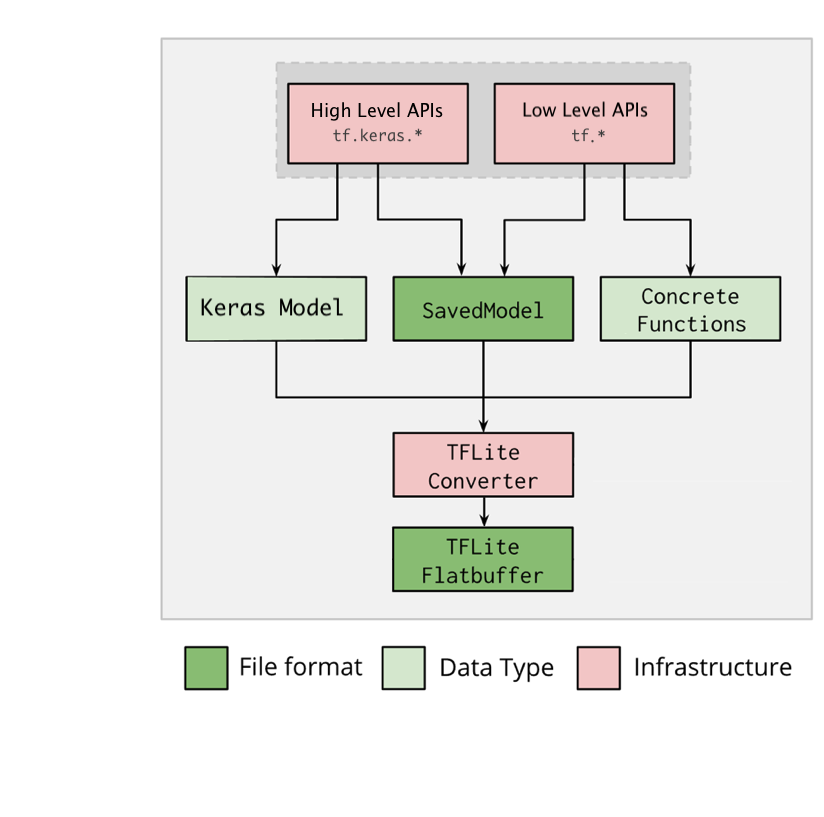


In [ ]:
model.summary()

In [ ]:
#if ensemble_learning_models:
test_ds = get_test_dataset(ordered=True)
        #best_alpha = 0.35
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)


print('Generating submission.csv file...')
        # Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

        # Write the submission file
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
        # Look at the first few predictions


In [ ]:
 !head submission.csv

In [ ]:
print(checkpoint_filepath)
tflite_model_name = checkpoint_filepath.replace(".h5" , ".tflite")
tflite_model_name

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)
    
print('TFLiteConversion completed successfully \U0001F680')  

### Ensemble Learning

In [ ]:
def get_pretrained_model(model_name, image_dataset_weights, trainable=True):
    pretrained_model= model_name(
        include_top=False ,
        weights=image_dataset_weights, #tuning10 weights='noisy-student' instead of 'imagenet'
                                       #Self-training with Noisy Student improves ImageNet classification https://arxiv.org/abs/1911.04252) 
        input_shape=[*IMAGE_SIZE, 3]
    )

    pretrained_model.trainable = trainable #tuning8 pretrained_model.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model, 
        tf.keras.layers.GlobalAveragePooling2D(), 
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    return model

In [ ]:
models = []
histories = []

In [ ]:
!pip install -q efficientnet

import efficientnet.tfkeras as efn

In [ ]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    enet = efn.EfficientNetB7(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        weights='imagenet',
        include_top=False
    )
    
    enet.trainable = True

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
            
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

models.append(model)

In [ ]:
history = model.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback],
    validation_data=None if ensemble_learning_models else get_validation_dataset()
)

histories.append(history)

In [ ]:
if not ensemble_learning_models:
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
with strategy.scope():
    rnet = DenseNet201(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        weights='imagenet',
        include_top=False
    )
    
    rnet.trainable = True

    model = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

models.append(model)

In [ ]:
history = model.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    validation_data=None if ensemble_learning_models else get_validation_dataset()
)

histories.append(history)

In [ ]:
if not ensemble_learning_models:
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

In [ ]:
if not ensemble_learning_models:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    cm_probabilities = (models[0].predict(images_ds) + models[1].predict(images_ds)) / 2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

if not ensemble_learning_models:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    plot_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [ ]:
if not ensemble_learning_models:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch

    m1 = models[0].predict(images_ds)
    m2 = models[1].predict(images_ds)

    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m1+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    plt.plot(scores)

    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha*m1+(1-best_alpha)*m2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)


In [ ]:
if not ensemble_learning_models:
    print(best_alpha, max(scores))

In [ ]:
if not ensemble_learning_models:
    test_ds = get_test_dataset(ordered=True)
    #best_alpha = 0.35

    print('Computing predictions...')
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities1 = models[0].predict(test_images_ds)
    probabilities2 = models[1].predict(test_images_ds)

    probabilities = best_alpha * probabilities1 + (1 - best_alpha) * probabilities2

    predictions = np.argmax(probabilities, axis=-1)
    print(predictions)

    print('Generating submission.csv file...')
    # Get image ids from test set and convert to unicode
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

    # Write the submission file
    np.savetxt(
        '../working/sample_submission.csv',
        np.rec.fromarrays([test_ids, predictions]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='id,label',
        comments='',
    )

    # Look at the first few predictions
   

In [ ]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

if not ensemble_learning_models:
    print('using_ensemble_models')
    probabilities1 = models[0].predict(images_ds)
    probabilities2 = models[1].predict(images_ds)
    cm_probabilities = best_alpha * probabilities1 + (1 - best_alpha) * probabilities2
else:
    cm_probabilities = model.predict(images_ds)
    
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

In [ ]:
cmat

In [ ]:
 !head sample_submission.csv